In [1]:
# to get started, we will import these libraries
import urllib.request, json 
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from sodapy import Socrata

# for interactive plots
import plotly.express as px
import folium

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
# next we will connect to the data portal to load in vacant parcel data from LA County Assessor
client = Socrata("data.lacounty.gov", None)

# The website says this dataset has 176K rows, we are going to try to call in all of them using 180K in case more have been added. However, we are also going to limit our data to Los Angeles incorporated
results = client.get("vcaw-zeg9", limit=180000, where="taxratearea_city=='LOS ANGELES'")

# We'll need to convert to pandas DataFrame
vacdf = pd.DataFrame.from_records(results)

vacdf.sample(5)

usecodedescchar1 roll_homeownersexemp situsunit recordingdate  \
31286       Industrial                    0                19841130   
30904       Commercial                    0                19990208   
3111       Residential                    0                20091216   
20749      Residential                    0                20020401   
31976      Residential                    0                20120319   

      effectiveyearbuilt istaxableparcel roll_totlandimp roll_perspropexemp  \
31286                  0               N               0                  0   
30904                  0               Y          134909                  0   
3111                   0               Y            1224                  0   
20749                  0               Y            3644                  0   
31976                  0               Y           30572                  0   

                               parcelboundarydescription roll_landbaseyear  \
31286               TR=2016*(EX OF ST) LOT    5 BLK   14              1985   
30904                    TRACT NO 5702 LOT   18 BLK    5              1991   
3111   TRACT # 10484 NW 14 FT MEASURED AT R/A TO NW L...              2002   
20749  HIGHLAND VIEW TRACT AS PER BK 9 PG 25 TO 34 OF...              1975   
31976  TRACT # 7117 LOT COM AT MOST E COR OF LOT 18 T...              1975   

       ...                                         location_1 bathrooms  \
31286  ...  {'latitude': '33.7819062', 'needs_recoding': F...         0   
30904  ...  {'latitude': '33.7899289', 'needs_recoding': F...         0   
3111   ...  {'latitude': '34.14110796', 'needs_recoding': ...         0   
20749  ...  {'latitude': '34.08967949', 'needs_recoding': ...         0   
31976  ...  {'latitude': '33.71318622', 'needs_recoding': ...         0   

      sqftmain situsdirection roll_realestateexemp   center_lat    situszip  \
31286        0                                   0  33.78190620               
30904        0              E                    0  33.78992890  90744-2904   
3111         0                                   0  34.14110796               
20749        0                                   0  34.08967949               
31976        0                                   0  33.71318622               

      yearbuilt                    propertylocation situszip5  
31286         0                                 NaN       NaN  
30904         0  1845 E M ST  LOS ANGELES CA  90744     90744  
3111          0                                 NaN       NaN  
20749         0                                 NaN       NaN  
31976         0                                 NaN       NaN  

[5 rows x 51 columns]

In [3]:
vacdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33091 entries, 0 to 33090
Data columns (total 51 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   usecodedescchar1           33080 non-null  object
 1   roll_homeownersexemp       33091 non-null  object
 2   situsunit                  33091 non-null  object
 3   recordingdate              33091 non-null  object
 4   effectiveyearbuilt         33091 non-null  object
 5   istaxableparcel            33091 non-null  object
 6   roll_totlandimp            33091 non-null  object
 7   roll_perspropexemp         33091 non-null  object
 8   parcelboundarydescription  33091 non-null  object
 9   roll_landbaseyear          33091 non-null  object
 10  situscity                  33091 non-null  object
 11  roll_impbaseyear           33091 non-null  object
 12  usetype                    33080 non-null  object
 13  cluster                    33091 non-null  object
 14  adminr

In [4]:
vacgdf = gpd.GeoDataFrame(vacdf, 
                       crs='epsg:4326',
                       geometry=gpd.points_from_xy(vacdf.center_lon, vacdf.center_lat))

In [5]:
# import the community boundaries dataset by referencing API from data source

import shapely
from shapely.geometry import shape

comdf = pd.read_json( r'https://data.lacounty.gov/resource/frhs-h972.json' )
comdf['the_geom'] = comdf['the_geom'].apply(shape)
comgdf = gpd.GeoDataFrame(comdf).set_geometry('the_geom')

comgdf.sample(5)

objectid city_type          lcity                       label   source  \
307       165      City    Los Angeles        Los Angeles - Venice  LA City   
238        79      City    Los Angeles  Los Angeles - Elysian Park  LA City   
318       190      City  Monterey Park       City of Monterey Park      BOS   
174        82      City    Los Angeles    Los Angeles - Exposition  LA City   
101        21      City    Culver City         City of Culver City      BOS   

     shape_starea  shape_stlength  \
307  7.791742e+07    42922.869737   
238  4.879123e+07    39718.047521   
318  2.156887e+08    79691.167948   
174  9.822072e+06    13747.787962   
101  1.431465e+08   116904.200144   

                                              the_geom     community  
307  MULTIPOLYGON (((-118.44336 33.99531, -118.4433...        Venice  
238  MULTIPOLYGON (((-118.22788 34.08316, -118.2276...  Elysian Park  
318  MULTIPOLYGON (((-118.10746 34.07155, -118.1074...           NaN  
174  MULTIPOLYGON (((-118.34603 34.02149, -118.3461...    Exposition  
101  MULTIPOLYGON (((-118.37077 34.03244, -118.3709...           NaN

In [6]:
comgdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   objectid        348 non-null    int64   
 1   city_type       348 non-null    object  
 2   lcity           348 non-null    object  
 3   label           348 non-null    object  
 4   source          348 non-null    object  
 5   shape_starea    348 non-null    float64 
 6   shape_stlength  348 non-null    float64 
 7   the_geom        348 non-null    geometry
 8   community       261 non-null    object  
dtypes: float64(2), geometry(1), int64(1), object(5)
memory usage: 24.6+ KB


In [7]:
comgdf = comgdf.set_crs('epsg:4326')

In [8]:
comgdf.head()

objectid       city_type           lcity  \
0         1            City    Agoura Hills   
1       214            City     Temple City   
2        95            City     Los Angeles   
3       334  Unincorporated  Unincorporated   
4        55            City     Los Angeles   

                                      label   source  shape_starea  \
0                      City of Agoura Hills      BOS  2.179401e+08   
1                       City of Temple City      BOS  1.122325e+08   
2             Los Angeles - Harvard Heights  LA City  2.089842e+07   
3  Unincorporated - Westfield/Academy Hills      BOS  1.459186e+07   
4               Los Angeles - Beverly Crest  LA City  2.342333e+08   

   shape_stlength                                           the_geom  \
0    80374.083443  MULTIPOLYGON (((-118.72864 34.16793, -118.7286...   
1    60506.140608  MULTIPOLYGON (((-118.05659 34.11841, -118.0563...   
2    21077.385705  MULTIPOLYGON (((-118.29156 34.04000, -118.2923...   
3    17831.004587  MULTIPOLYGON (((-118.34845 33.77939, -118.3488...   
4   110820.548509  MULTIPOLYGON (((-118.40751 34.12945, -118.4074...   

                 community  
0                      NaN  
1                      NaN  
2          Harvard Heights  
3  Westfield/Academy Hills  
4            Beverly Crest

In [9]:
comgdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   objectid        348 non-null    int64   
 1   city_type       348 non-null    object  
 2   lcity           348 non-null    object  
 3   label           348 non-null    object  
 4   source          348 non-null    object  
 5   shape_starea    348 non-null    float64 
 6   shape_stlength  348 non-null    float64 
 7   the_geom        348 non-null    geometry
 8   community       261 non-null    object  
dtypes: float64(2), geometry(1), int64(1), object(5)
memory usage: 24.6+ KB


In [10]:
com_new = comgdf.loc[[68,134,152,123,116, 21, 95, 262, 228, 198 ]]

In [11]:
def vacantparcel_map(community = 'Boyle Heights', column = 'usecodedescchar1'):
    # neighborhood
    
    neighb = comgdf[comgdf['community']==community]
    
    # spatial join to get parks
    vacmap = gpd.sjoin(vacgdf,neighb)

    # plot vacant lots
    fig,ax = plt.subplots(figsize=(15,15))
    
    # plot neighborhood boundaries
    neighb.plot(ax=ax, # this puts it in the ax plot
        color='gray', 
        edgecolor='white',
        alpha=0.2)

    # map
    vacmap.plot(ax=ax,
                column=column,
                legend=True)

    ax.axis('off')
    ax.set_title('Vacant Parcels in ' + community + ' Neighborhood', fontsize=14)
    
    #add basemap
    ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=comgdf.crs)

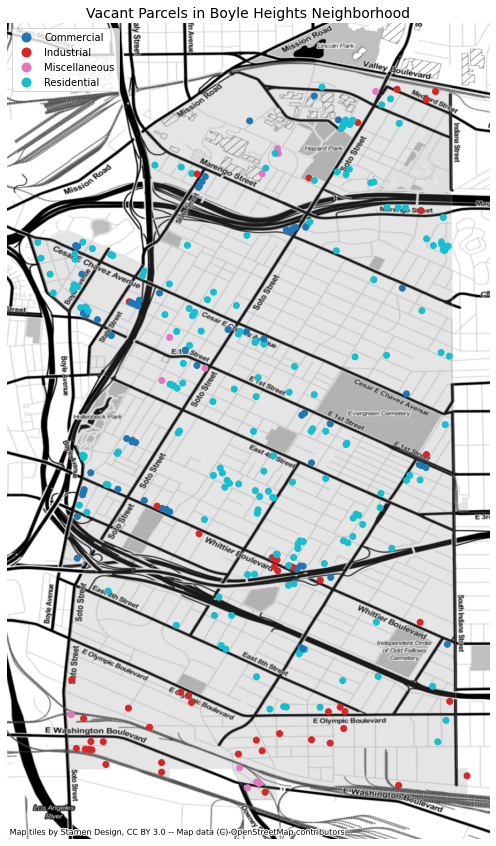

In [12]:
#check that it works
vacantparcel_map()

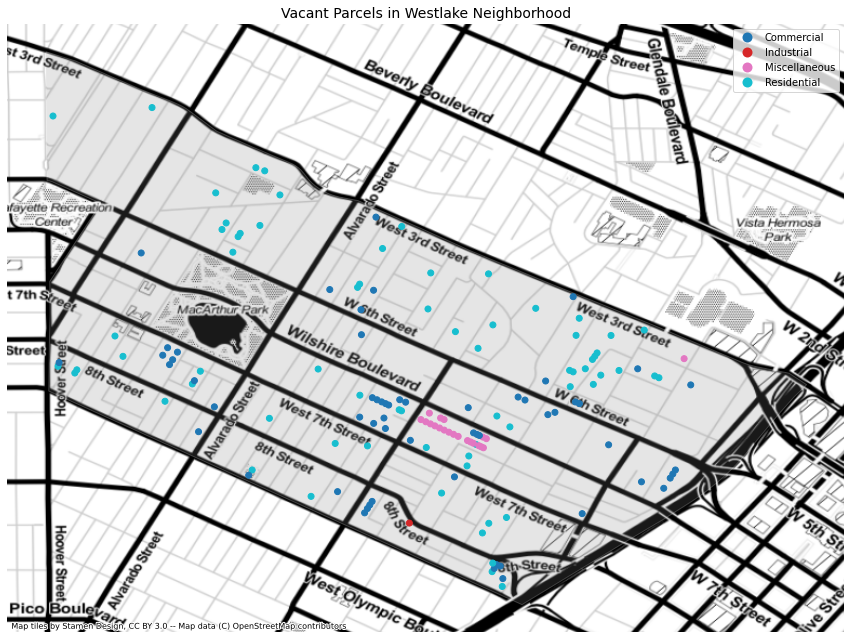

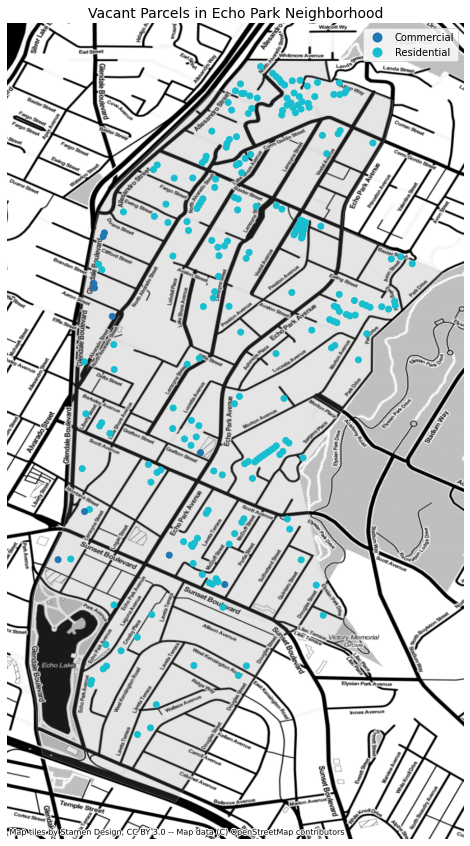

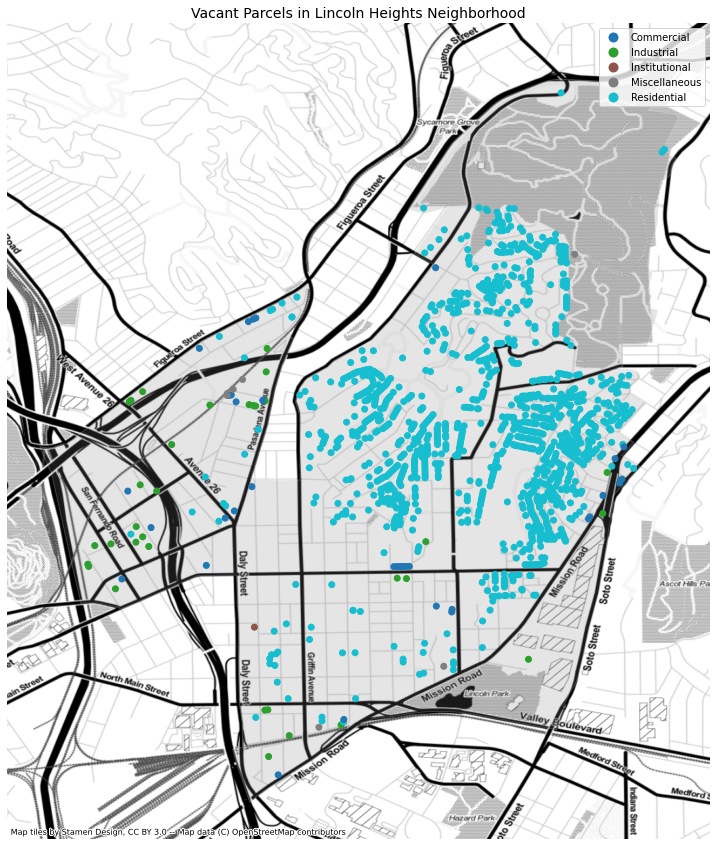

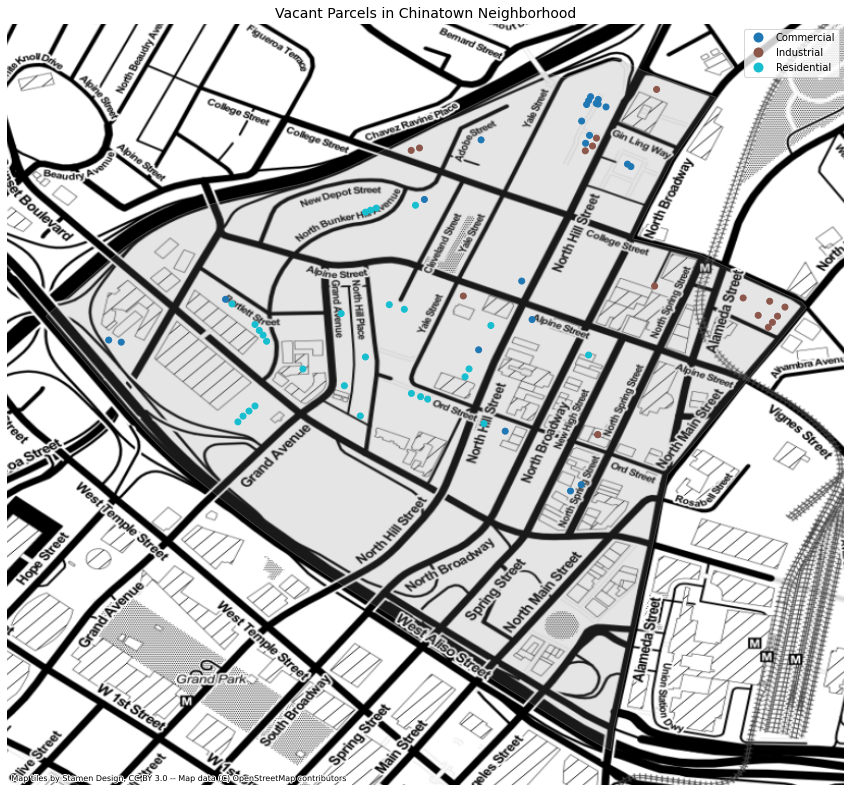

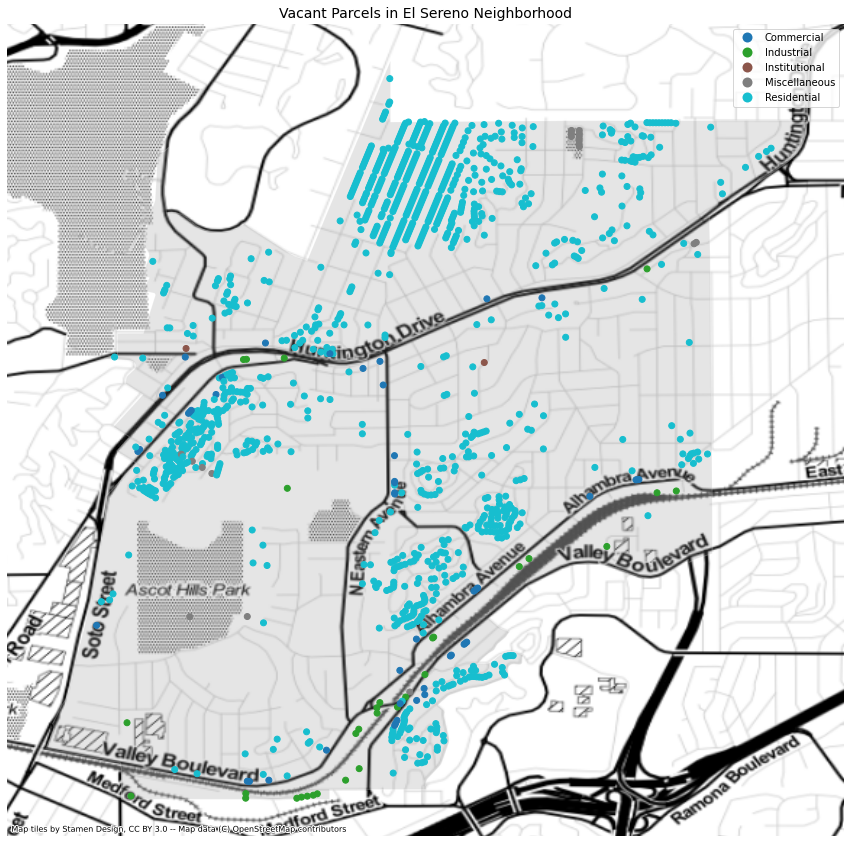

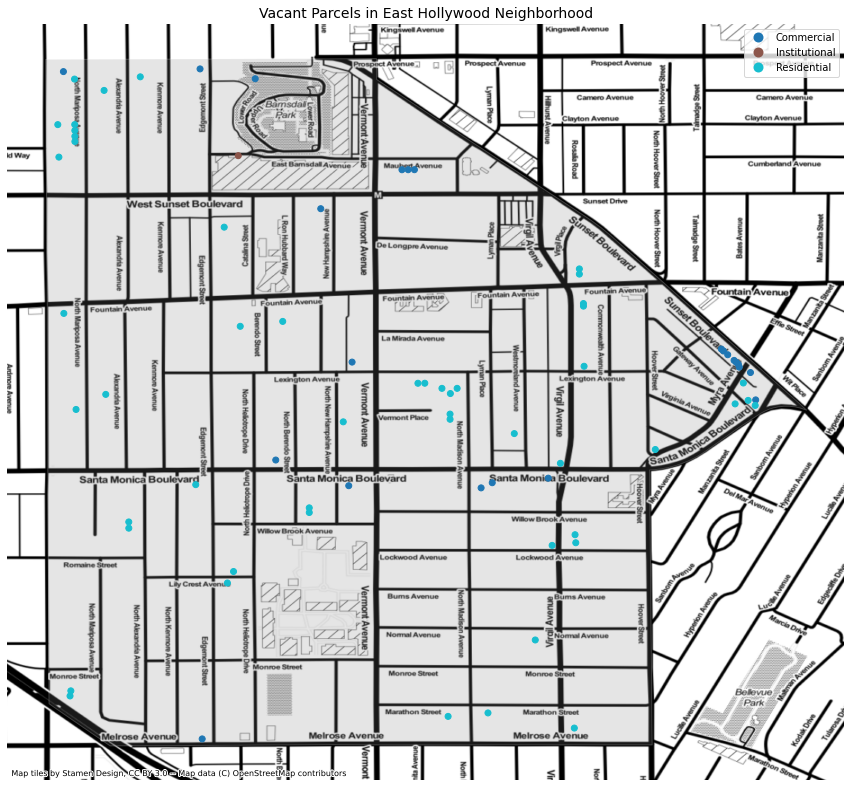

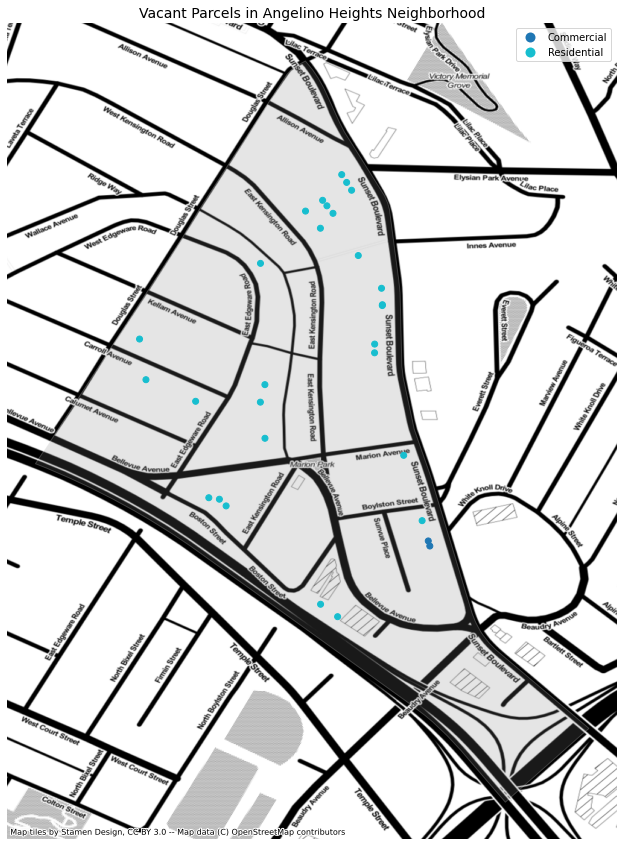

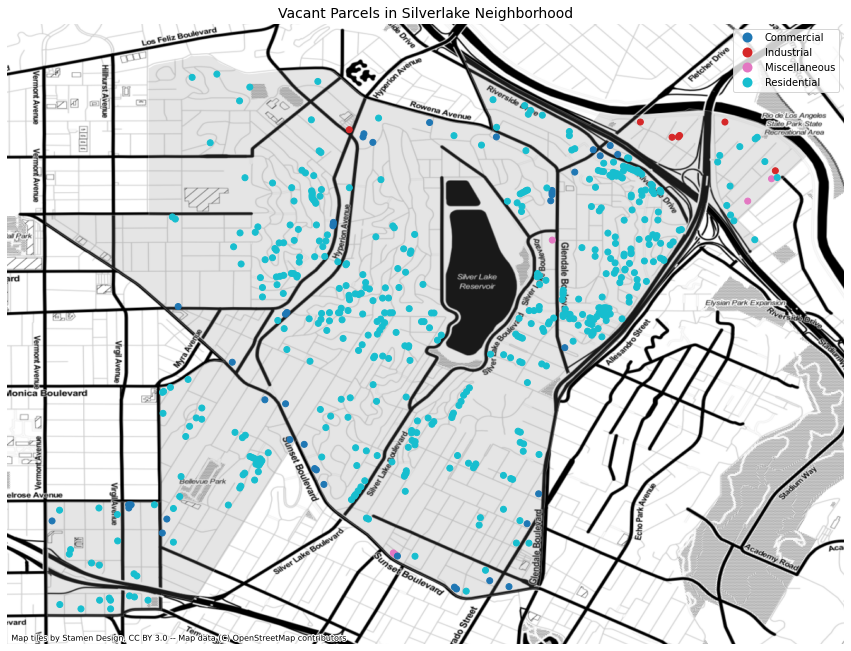

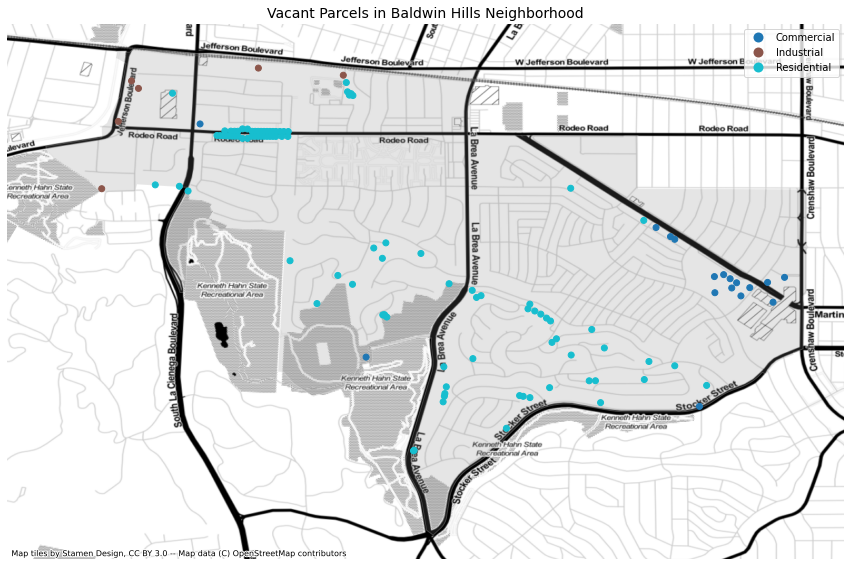

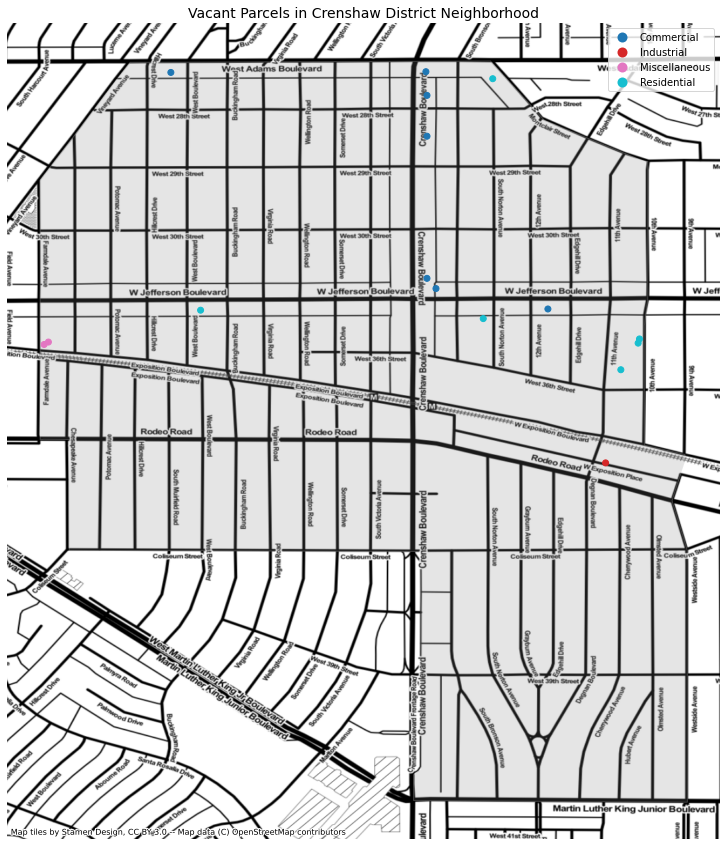

In [13]:
#loop through the CDs
for index, row in com_new.iterrows():
    vacantparcel_map(community = row['community'])